<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/utterance_generation/Utterance%20Generation%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 24 14:18 .
drwxr-xr-x 4 root root 4.0K Jun 24 14:18 ..
-rw-r--r-- 1 root root 5.6M Jun 24 14:18 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 24 14:18 original
-rw-r--r-- 1 root root  49M Jun 24 14:18 test.tsv
-rw-r--r-- 1 root root  50M Jun 24 14:18 train.tsv


In [2]:
import time
import random
import math
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [6]:
len(train_df), len(valid_df)

(363192, 40372)

Text(0.5, 0, 'Train data distribution')

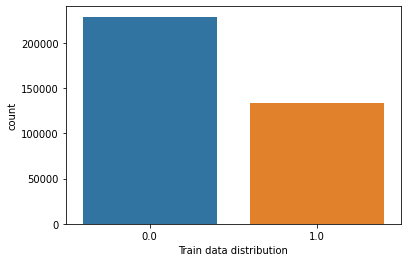

In [7]:
sns.countplot(train_df['is_duplicate'])
plt.xlabel('Train data distribution')

Text(0.5, 0, 'Valid data distribution')

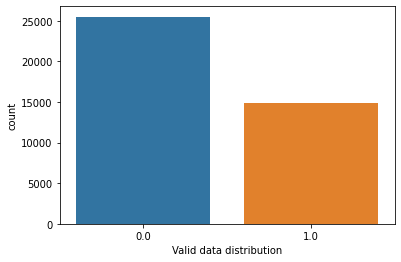

In [8]:
sns.countplot(valid_df['is_duplicate'])
plt.xlabel('Valid data distribution')

In [9]:
train_data = train_df[train_df['is_duplicate'] == 1]
valid_data = valid_df[valid_df['is_duplicate'] == 1]

In [10]:
len(train_data), len(valid_data)

(134141, 14857)

In [11]:
train_data = train_data[['question1', 'question2']]
valid_data = valid_data[['question1', 'question2']]

In [12]:
train_data.head()

,question1,question2
1,How do I control my horny emotions?,How do you control your horniness?
3,What can one do after MBBS?,What do i do after my MBBS ?
7,What is the best self help book you have read?...,What are the top self help books I should read?
11,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...
13,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?


In [13]:
sample_train_data = train_data.sample(50000)
sample_valid_data = valid_data.sample(5000)

In [14]:
sample_train_data.to_csv('train_ds.csv')
sample_valid_data.to_csv('valid_ds.csv')

In [15]:
!ls -lah

total 6.1M
drwxr-xr-x 1 root root 4.0K Jun 24 14:19 .
drwxr-xr-x 1 root root 4.0K Jun 24 14:14 ..
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 4 root root 4.0K Jun 24 14:18 glue_data
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root 5.5M Jun 24 14:19 train_ds.csv
-rw-r--r-- 1 root root 558K Jun 24 14:19 valid_ds.csv


In [40]:
tokenizer = data.get_tokenizer('spacy')
TEXT = data.Field(tokenize=tokenizer, lower=True, init_token='<sos>', eos_token='<eos>', batch_first=True)

In [41]:
fields = [(None, None), ("source", TEXT), ("target", TEXT)]

train_dataset, valid_dataset = data.TabularDataset.splits(path='.',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=fields)

In [42]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")

Number of training examples: 50000
Number of validation examples: 5000


In [43]:
print(vars(train_dataset.examples[1]))

{'source': ['what', 'are', 'complex', 'networks', '?'], 'target': ['what', 'defines', 'a', 'complex', 'network', '?']}


In [44]:
TEXT.build_vocab(train_dataset, min_freq=5)

In [45]:
print(f"Number of tokens in vocabulary: {len(TEXT.vocab)}")

Number of tokens in vocabulary: 8130


In [46]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.source),
    device=device
)

In [47]:
# sample checking
temp = next(iter(train_iterator))
temp.source.shape, temp.target.shape

(torch.Size([64, 32]), torch.Size([64, 47]))

In [48]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, device):
        super().__init__()

        assert d_model % n_heads == 0, "n_heads must be a factor of d_model"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        # query => [batch_size, seq_len, d_model] 
        # key => [batch_size, seq_len, d_model]
        # value => [batch_size, seq_len, d_model]

        batch_size = query.shape[0]

        Q = self.q(query)
        K = self.k(key)
        V = self.v(value)
        # Q, K, V => [batch_size, seq_len, d_model]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q, K, V => [batch_size, n_heads, seq_len, head_dim]

        energy = torch.matmul(Q, K.permute(0 ,1, 3, 2))
        energy = energy / self.scale
        # energy => [batch_size, n_heads, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        # attention => [batch_size, n_heads, query_len, key_len]

        weighted = torch.matmul(attention, V)
        # weighted => [batch_size, n_heads, query_len, head_dim]

        weighted = weighted.permute(0, 2, 1, 3).contiguous()
        # weighted => [batch_size, query_len, n_heads, head_dim]

        x = weighted.view(batch_size, -1, self.d_model)
        # x => [batch_size, query_len, d_model]

        x = self.fc(x)
        # x => [batch_size, query_len, d_model]
        # attention => [batch_size, n_heads, query_len, key_len]

        return x, attention


In [49]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, pff_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, pff_dim)
        self.fc2 = nn.Linear(pff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # input => [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.fc1(input)))
        # x => [batch_size, seq_len, pff_dim]

        x = self.fc2(x)
        # x => [batch_size, seq_len, d_model]

        return x


In [50]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src => [batch_size, src_len, d_model]

        # self attention on src
        _src, _ = self.self_attention(src, src, src, src_mask)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        # position wise feed forward
        _src = self.pff(src)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.pff_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        return src

In [51]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pff_dim, dropout, device, max_len=500):
        super().__init__()

        self.n_layers = n_layers
        self.device = device
        self.word_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pff_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, src, src_mask):
        # src => [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, src_len]

        word_embed = self.word_embedding(src)
        word_embed = word_embed * self.scale
        # word_embed => [batch_size, src_len, d_model]

        pos_embed = self.pos_embedding(pos)
        # pos_embed => [batch_size, src_len, d_model]

        src = self.dropout(word_embed + pos_embed)
        # src => [batch_size, src_len, d_model]

        for layer in self.layers:
            src = layer(src, src_mask)
        
        # src => [batch_size, src_len, d_model]
        return src


In [52]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.enc_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # enc_attention
        _trg, attention = self.enc_attention(trg, enc_src, enc_src, src_mask)
        # _trg => [batch_size, trg_len, d_model]
        # attention => [batch_size, n_heads, trg_len, src_len]

        # residual connection and layer normalization
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # positionwise feed forward
        _trg = self.pff(trg)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.pff_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        return trg, attention


In [53]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pff_dim, dropout, device, max_len=500):
        super().__init__()
        
        self.device = device
        self.word_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pff_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(d_model, output_dim)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, trg_len]

        word_embedding = self.word_embedding(trg)
        word_embedding = word_embedding * self.scale
        # word_embedding => [batch_size, trg_len, d_model]

        pos_embedding = self.pos_embedding(pos)
        # pos_embedding => [batch_size, trg_len, d_model]

        trg = self.dropout(word_embedding + pos_embedding)
        # trg => [batch_size, trg_len, d_model]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        logits = self.fc_out(trg)
        # logits => [batch_size, trg_len, output_dim]
        # attention => [batch_size, n_heads, trg_len, src_len]

        return logits, attention


In [54]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        # src_mask => [batch_size, 1, 1, src_len]
        
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask => [batch_size, 1, trg_len, trg_len]

        return trg_mask
 
    def forward(self, src, trg):
        # src => [batch_size, src_len]
        # trg => [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

In [55]:
INPUT_DIM = len(TEXT.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(INPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [56]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = Transformer(enc, dec, PAD_IDX, device).to(device)

In [57]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(8130, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): SelfAttention(
          (q): Linear(in_features=256, out_features=256, bias=True)
          (k): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (pff): PositionWiseFeedForward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,461,634 trainable parameters


In [59]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [60]:
def train(model, iterator, criterion, optimizer, clip):
    model.train()

    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.source
        trg = batch.target

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])
        # output => [batch_size, trg_len - 1, output_dim]
        # trg => [batch_size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [61]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.source
            trg = batch.target

            output, _ = model(src, trg[:, :-1])
            # output => [batch_size, trg_len - 1, output_dim]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [62]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [63]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss): 7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss): 7.3f}")

Epoch: 01 | Time: 1m 30.70790410041809s
	Train Loss: 4.039 | Train PPL:  56.769
	Valid Loss: 3.115 | Valid PPL:  22.524
Epoch: 02 | Time: 1m 30.02260184288025s
	Train Loss: 2.955 | Train PPL:  19.194
	Valid Loss: 2.619 | Valid PPL:  13.727
Epoch: 03 | Time: 1m 30.28101873397827s
	Train Loss: 2.508 | Train PPL:  12.278
	Valid Loss: 2.392 | Valid PPL:  10.936
Epoch: 04 | Time: 1m 29.946358680725098s
	Train Loss: 2.221 | Train PPL:   9.214
	Valid Loss: 2.242 | Valid PPL:   9.408
Epoch: 05 | Time: 1m 30.566269874572754s
	Train Loss: 2.014 | Train PPL:   7.495
	Valid Loss: 2.150 | Valid PPL:   8.582
Epoch: 06 | Time: 1m 30.16736102104187s
	Train Loss: 1.856 | Train PPL:   6.401
	Valid Loss: 2.103 | Valid PPL:   8.188
Epoch: 07 | Time: 1m 30.22304654121399s
	Train Loss: 1.732 | Train PPL:   5.650
	Valid Loss: 2.096 | Valid PPL:   8.136
Epoch: 08 | Time: 1m 30.58267378807068s
	Train Loss: 1.634 | Train PPL:   5.125
	Valid Loss: 2.056 | Valid PPL:   7.814
Epoch: 09 | Time: 1m 30.20843911170959

In [74]:
def generate_utterance(sentence, text_field, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [text_field.init_token] + tokens + [text_field.eos_token]
    
    # convert the tokens to ids  
    src_indexes = [text_field.vocab.stoi[token] for token in tokens]

    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor => [1, seq_len]

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    # the starting input to decoder is always <sos>
    trg_indexes = [text_field.vocab.stoi[text_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()

        trg_indexes.append(pred_token)

        # if the predicted token is <eos> means stop the decoding
        if pred_token == text_field.vocab.stoi[text_field.eos_token]:
            break
    
    # convert the predicted token ids to words
    trg_tokens = [text_field.vocab.itos[i] for i in trg_indexes]

    return tokens[1:-1], trg_tokens[1:], attention


In [65]:
def display_attention(sentence, utterance, attention, n_heads=8, n_rows=2, n_cols=4):
    
    fig = plt.figure(figsize=(25, 12))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='Blues')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + utterance)
        title = f"Attention Head: {i+1}"
        ax.set_xlabel(title)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['which', 'book', 'would', 'you', 'recommend', 'to', 'improve', 'english', '?']
trg = ['what', 'are', 'the', 'books', 'to', 'improve', 'english', '?']
generated utterance = ['what', 'are', 'some', 'of', 'the', 'best', 'books', 'to', 'learn', 'english', '?', '<eos>']


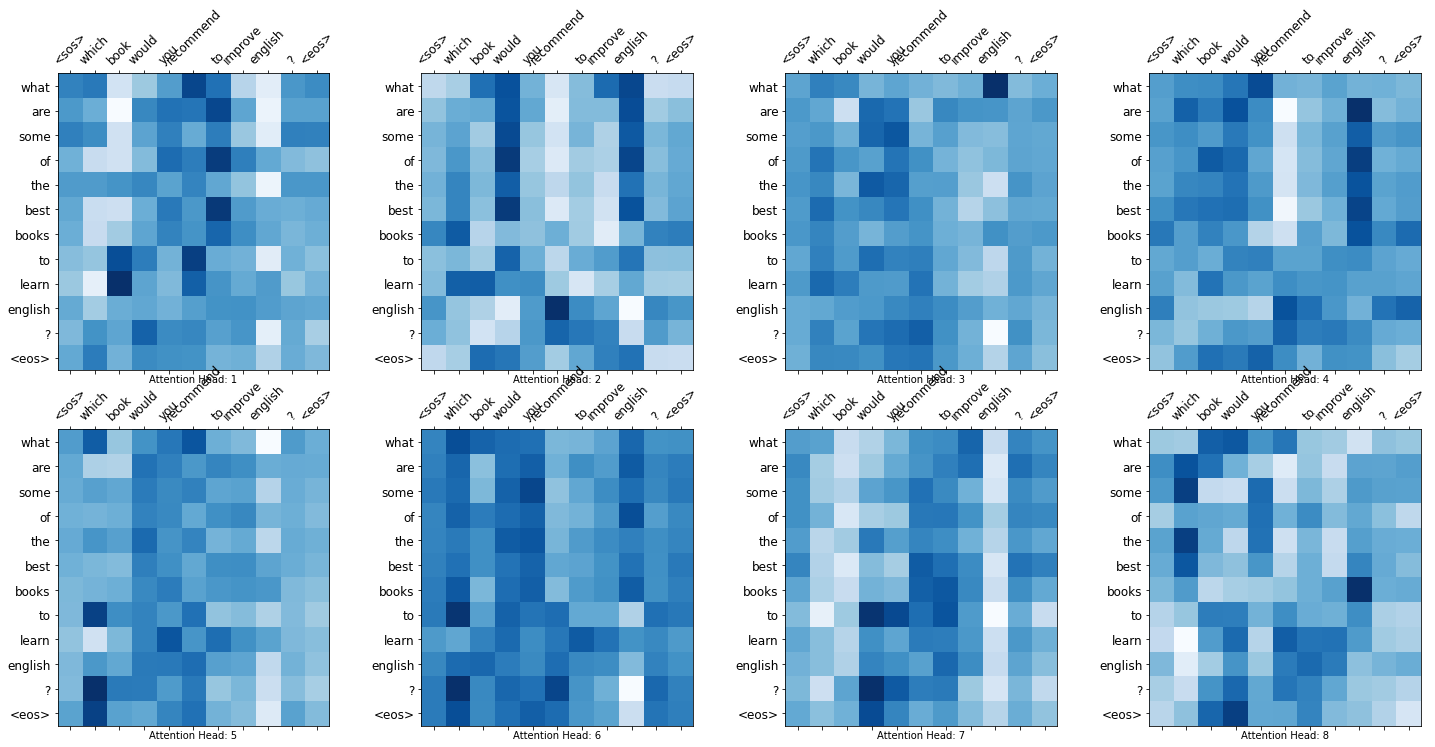

In [72]:
example_idx = 55

src = vars(valid_dataset.examples[example_idx])['source']
trg = vars(valid_dataset.examples[example_idx])['target']

print(f'src = {src}')
print(f'trg = {trg}')


_, utterance, attention = generate_utterance(src, TEXT, model, device)

print(f'generated utterance = {utterance}')

display_attention(src, utterance, attention)

src = ['what', 'can', 'i', 'do', 'after', 'engineering', '?']
generated utterance = ['what', 'should', 'i', 'do', 'after', 'engineering', '?', '<eos>']


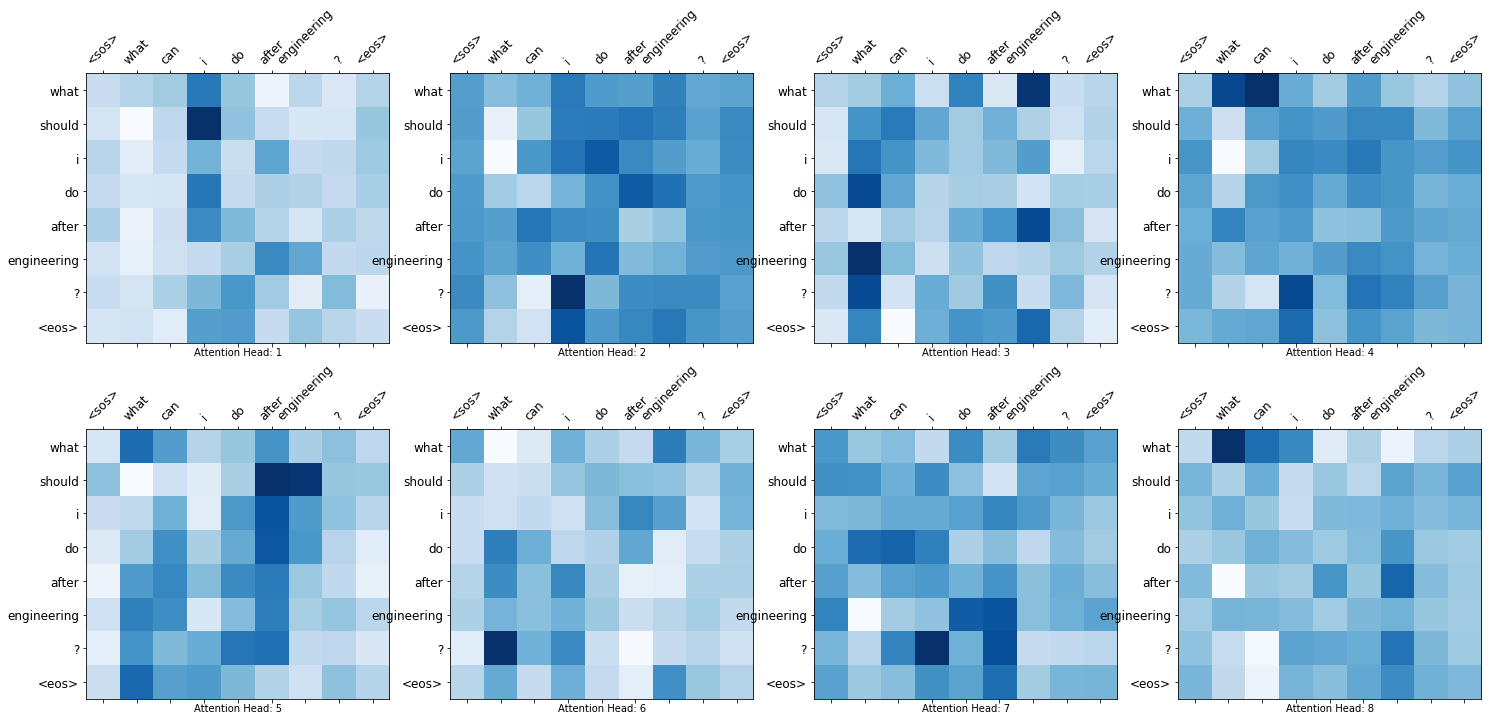

In [75]:
src = "What can I do after engineering?"

tokens, utterance, attention = generate_utterance(src, TEXT, model, device)

print(f'src = {tokens}')
print(f'generated utterance = {utterance}')

display_attention(tokens, utterance, attention)